In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cpu


In [5]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0,shear= 10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      
                                        transforms.ToTensor(), 
                                      transforms.Normalize((0.5,), (0.5, ))])


transform = transforms.Compose([transforms.Resize((32, 32)),
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=True, download = True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    return image

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horses', 'ship', 'truck')

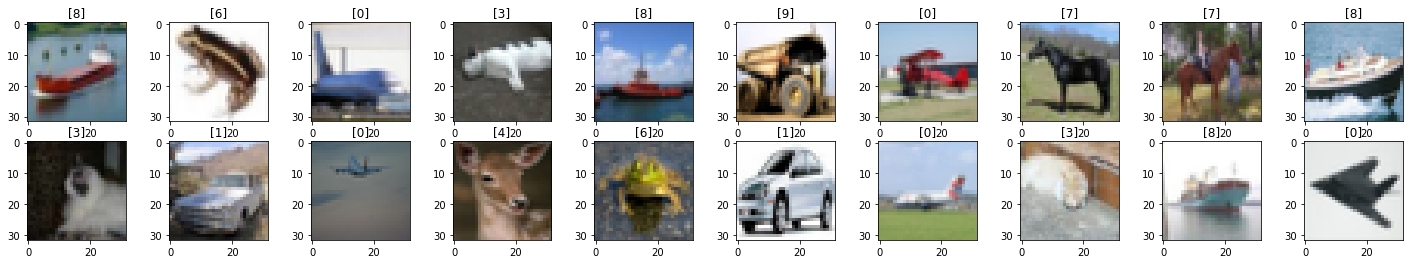

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])
    

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(5*5*50, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [10]:
model = LeNet()
model


LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
epochs = 15

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
            
        running_loss += loss.item()
        
        running_corrects+=torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
        
                val_running_corrects+=torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch : ', e+1)
        print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        
        

epoch :  1
training loss: 1.5084, accuracy 45.4400
validation loss: 1.2255, validation accuracy 56.0800
epoch :  2
training loss: 1.1433, accuracy 59.0160
validation loss: 1.0036, validation accuracy 64.2060
epoch :  3
training loss: 1.0018, accuracy 64.6720
validation loss: 0.9030, validation accuracy 68.4240
epoch :  4
training loss: 0.9032, accuracy 68.1040
validation loss: 0.8250, validation accuracy 71.1280
epoch :  5
training loss: 0.8254, accuracy 70.8780
validation loss: 0.7676, validation accuracy 73.0660
epoch :  6
training loss: 0.7645, accuracy 73.1120
validation loss: 0.6977, validation accuracy 75.4840
epoch :  7
training loss: 0.7169, accuracy 74.7600
validation loss: 0.6329, validation accuracy 77.6020
epoch :  8
training loss: 0.6616, accuracy 76.5840
validation loss: 0.5890, validation accuracy 79.1580
epoch :  9
training loss: 0.6223, accuracy 78.0980
validation loss: 0.5731, validation accuracy 79.7140
epoch :  10
training loss: 0.5812, accuracy 79.3020
validation l

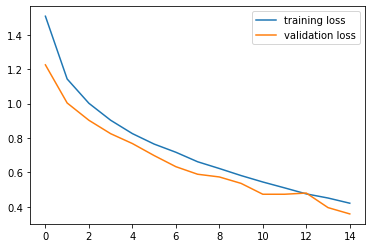

In [13]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

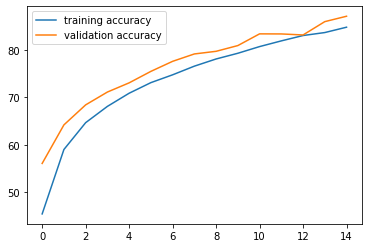

In [14]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

<Response [200]>


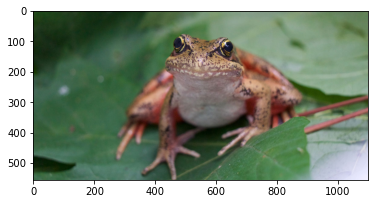

In [15]:
import requests
from PIL import Image
url = 'https://www.burkemuseum.org/sites/default/files/images/biology/herpetology/washington/northern-red-legged-frog1-1100x555.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

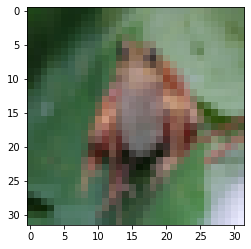

In [16]:

img = transform(img)

plt.imshow(im_convert(img))

In [17]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


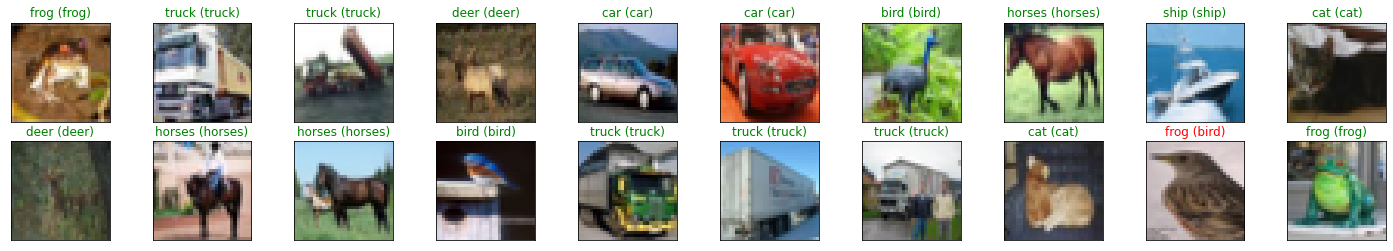

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))
    

We can see that there is an overfitting problem

### Retraining a model from scratch adding some conv layers

Here we added some conv layers to address overfitting. But it also results in an increase in number of parameters and of complexity of the model, which is a cause of overfitting. Then we are also trying to decrease kernel size to see if it leads to better results

In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [28]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [30]:
epochs = 15

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
            
        running_loss += loss.item()
        
        running_corrects+=torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
        
                val_running_corrects+=torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss/len(training_loader)
        epoch_acc = running_corrects.float()/len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch : ', e+1)
        print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        
        

epoch :  1
training loss: 1.2202, accuracy 56.0380
validation loss: 1.0880, validation accuracy 61.4000
epoch :  2
training loss: 1.0485, accuracy 62.7580
validation loss: 0.9762, validation accuracy 65.3360
epoch :  3
training loss: 0.9394, accuracy 66.5100
validation loss: 0.8498, validation accuracy 69.9420
epoch :  4
training loss: 0.8581, accuracy 69.9060
validation loss: 0.7880, validation accuracy 72.4600
epoch :  5
training loss: 0.7928, accuracy 71.9640
validation loss: 0.7382, validation accuracy 74.1080
epoch :  6
training loss: 0.7380, accuracy 74.1640
validation loss: 0.6680, validation accuracy 76.7060
epoch :  7
training loss: 0.6861, accuracy 75.9060
validation loss: 0.6464, validation accuracy 77.1220
epoch :  8
training loss: 0.6441, accuracy 77.3820
validation loss: 0.5677, validation accuracy 80.1020
epoch :  9
training loss: 0.6061, accuracy 78.7780
validation loss: 0.5634, validation accuracy 80.1980
epoch :  10
training loss: 0.5732, accuracy 79.8000
validation l

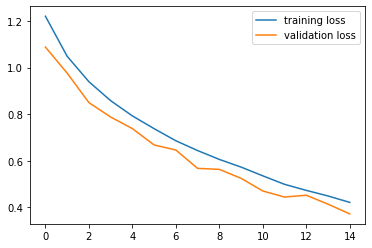

In [31]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

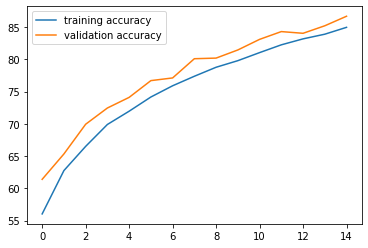

In [32]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

<Response [200]>


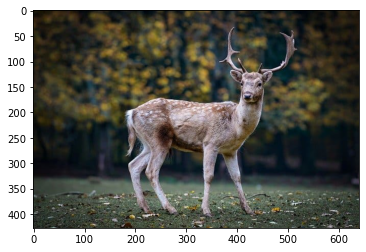

In [34]:
import requests
from PIL import Image
url = 'https://www.conserve-energy-future.com/wp-content/uploads/2019/12/nature-roe-deer-forest-fallow-deer.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

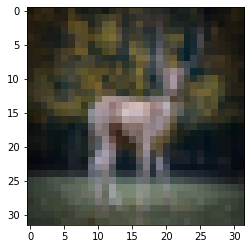

In [35]:
img = transform(img)

plt.imshow(im_convert(img))

In [36]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer
